Src:
* [A Friendly Introduction to Siamese Networks](https://builtin.com/machine-learning/siamese-network)

In [1]:
!unzip data.zip

Archive:  data.zip
   creating: test/049/
  inflating: test/049/01_049.png     
  inflating: test/049/02_049.png     
  inflating: test/049/03_049.png     
  inflating: test/049/04_049.png     
  inflating: test/049/05_049.png     
  inflating: test/049/06_049.png     
  inflating: test/049/07_049.png     
  inflating: test/049/08_049.png     
  inflating: test/049/09_049.png     
  inflating: test/049/10_049.png     
  inflating: test/049/11_049.png     
  inflating: test/049/12_049.png     
   creating: test/049_forg/
  inflating: test/049_forg/01_0114049.PNG  
  inflating: test/049_forg/01_0206049.PNG  
  inflating: test/049_forg/01_0210049.PNG  
  inflating: test/049_forg/02_0114049.PNG  
  inflating: test/049_forg/02_0206049.PNG  
  inflating: test/049_forg/02_0210049.PNG  
  inflating: test/049_forg/03_0114049.PNG  
  inflating: test/049_forg/03_0206049.PNG  
  inflating: test/049_forg/03_0210049.PNG  
  inflating: test/049_forg/04_0114049.PNG  
  inflating: test/049_forg/04_0206

In [2]:
import os
import pandas as pd
import numpy as np
from PIL import Image
import torch as th
from torch.utils.data import Dataset
from torchvision import transforms
import torch.nn as nn
from torch.utils.data import DataLoader
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torchvision


In [3]:
class SiameseDataset():
    def __init__(self,training_csv=None,training_dir=None,transform=None):
        self.train_df=pd.read_csv(training_csv)
        self.train_df.columns =["image1","image2","label"]
        self.train_dir = training_dir
        self.transform = transform

    def __getitem__(self,index):
        image1_path=os.path.join(self.train_dir,self.train_df.iat[index,0])
        image2_path=os.path.join(self.train_dir,self.train_df.iat[index,1])

        img0 = Image.open(image1_path)
        img0 = img0.convert("L")

        img1 = Image.open(image2_path)
        img1 = img1.convert("L")

        if self.transform is not None:
            img0 = self.transform(img0)
            img1 = self.transform(img1)
        return img0, img1 , th.from_numpy(np.array([int(self.train_df.iat[index,2])],dtype=np.float32))

    def __len__(self):
        return len(self.train_df)

In [4]:
training_dir = "train"
training_csv = "train_data.csv"
siamese_dataset = SiameseDataset(training_csv,training_dir,transform=transforms.Compose([transforms.Resize((105,105)),transforms.ToTensor()]))

In [5]:
class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()
        self.cnn1 = nn.Sequential(
            nn.Conv2d(1, 96, kernel_size=11,stride=1),
            nn.ReLU(inplace=True),
            nn.LocalResponseNorm(5,alpha=0.0001,beta=0.75,k=2),
            nn.MaxPool2d(3, stride=2),

            nn.Conv2d(96, 256, kernel_size=5,stride=1,padding=2),
            nn.ReLU(inplace=True),
            nn.LocalResponseNorm(5,alpha=0.0001,beta=0.75,k=2),
            nn.MaxPool2d(3, stride=2),
            nn.Dropout2d(p=0.3),

            nn.Conv2d(256,384 , kernel_size=3,stride=1,padding=1),
            nn.ReLU(inplace=True),

            nn.Conv2d(384,256 , kernel_size=3,stride=1,padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(3, stride=2),
            nn.Dropout2d(p=0.3),
        )
        self.fc1 = nn.Sequential(
            nn.Linear(30976, 1024),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5),

            nn.Linear(1024, 128),
            nn.ReLU(inplace=True),

            nn.Linear(128,2))

    def forward_once(self, x):
        output = self.cnn1(x)
        output = output.view(output.size()[0], -1)
        output = self.fc1(output)
        return output

    def forward(self, input1, input2):
        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)
        return output1, output2

In [6]:
class ContrastiveLoss(th.nn.Module):
    """
    Contrastive loss function.
    Based on:
    """

    def __init__(self, margin=1.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, x0, x1, y):
        diff = x0 - x1
        dist_sq = th.sum(th.pow(diff, 2), 1)
        dist = th.sqrt(dist_sq)

        mdist = self.margin - dist
        dist = th.clamp(mdist, min=0.0)
        loss = y * dist_sq + (1 - y) * th.pow(dist, 2)
        loss = th.sum(loss) / 2.0 / x0.size()[0]
        return loss

In [7]:
def show_plot(iterations, loss_values):
    plt.figure(figsize=(8, 6))
    plt.plot(iterations, loss_values, label='Loss')
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.title("Training Loss Curve")
    plt.legend()
    plt.grid()
    plt.show()

In [8]:
net = SiameseNetwork().cuda()
criterion = ContrastiveLoss()
optimizer = th.optim.Adam(net.parameters(), lr=1e-3, weight_decay=0.0005)

In [9]:
batch_size = 32
epochs = 3

In [10]:
train_dataloader = DataLoader(siamese_dataset, num_workers=0, batch_size=batch_size, shuffle=True)

In [11]:
def train():
    loss=[]
    counter=[]
    iteration_number = 0
    for epoch in range(1, epochs):
        for i, data in enumerate(train_dataloader,0):
            img0, img1 , label = data
            img0, img1 , label = img0.cuda(), img1.cuda() , label.cuda()
            optimizer.zero_grad()
            output1,output2 = net(img0,img1)
            loss_contrastive = criterion(output1,output2,label)
            loss_contrastive.backward()
            optimizer.step()
        print("Epoch {}\n Current loss {}\n".format(epoch,loss_contrastive.item()))
        iteration_number += 10
        counter.append(iteration_number)
        loss.append(loss_contrastive.item())
    show_plot(counter, loss)
    return net

Epoch 1
 Current loss 0.7858291864395142

Epoch 2
 Current loss 0.7354167103767395



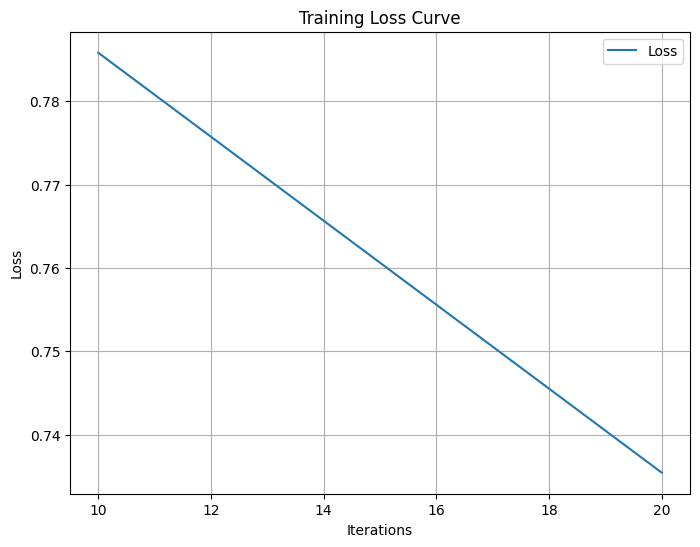

Model Saved Successfully


In [12]:
device = th.device('cuda' if th.cuda.is_available() else 'cpu')
net.to(device)
model = train()
th.save(model.state_dict(), "model.pt")
print("Model Saved Successfully")

In [13]:
testing_dir = "test"
testing_csv = "test_data.csv"
test_dataset = SiameseDataset(training_csv=testing_csv, training_dir=testing_dir, transform=transforms.Compose([transforms.Resize((105,105)), transforms.ToTensor()]))
test_dataloader = DataLoader(test_dataset,num_workers=2,batch_size=1,shuffle=True)

In [14]:
def imshow(img, text=None, should_save=False):
    npimg = img.numpy()
    plt.axis("off")
    if text:
        plt.text(
            75,
            8,
            text,
            style="italic",
            fontweight="bold",
            bbox={"facecolor": "white", "alpha": 0.8, "pad": 10},
        )
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

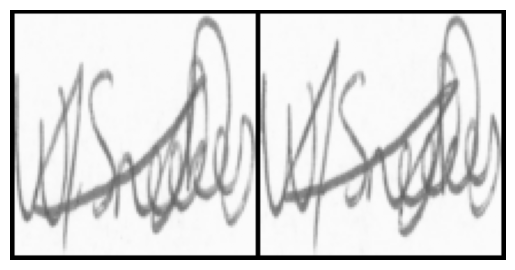

Predicted Eucledian Distance:- 0.5401149392127991
Actual Label:- Original Pair Of Signature


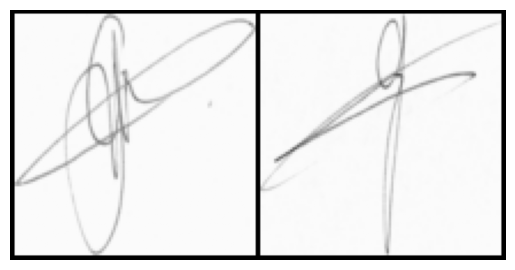

Predicted Eucledian Distance:- 0.5902127623558044
Actual Label:- Forged Pair Of Signature


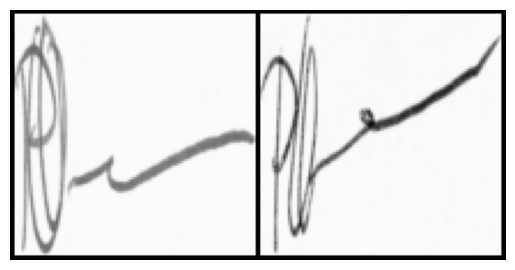

Predicted Eucledian Distance:- 0.31010153889656067
Actual Label:- Forged Pair Of Signature


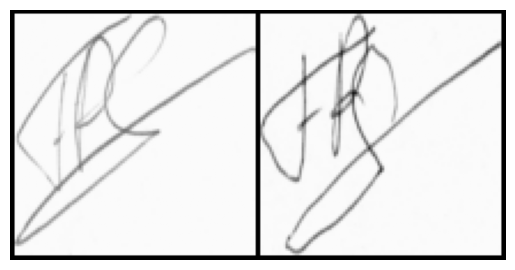

Predicted Eucledian Distance:- 0.3833945095539093
Actual Label:- Forged Pair Of Signature


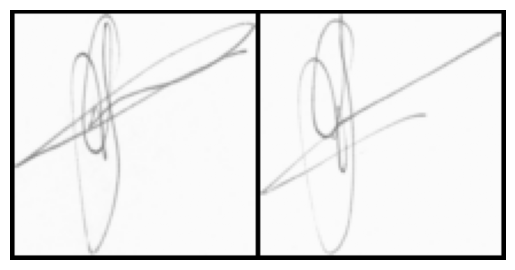

Predicted Eucledian Distance:- 0.09240645915269852
Actual Label:- Original Pair Of Signature


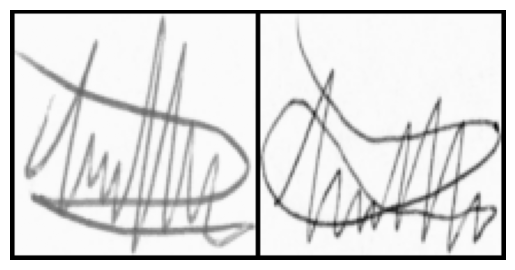

Predicted Eucledian Distance:- 0.5553063154220581
Actual Label:- Forged Pair Of Signature


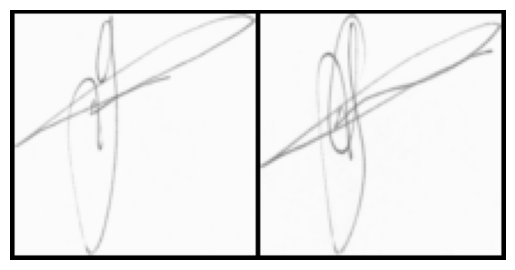

Predicted Eucledian Distance:- 0.7676470279693604
Actual Label:- Original Pair Of Signature


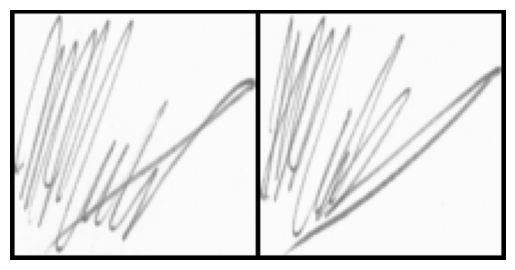

Predicted Eucledian Distance:- 0.6913604140281677
Actual Label:- Original Pair Of Signature


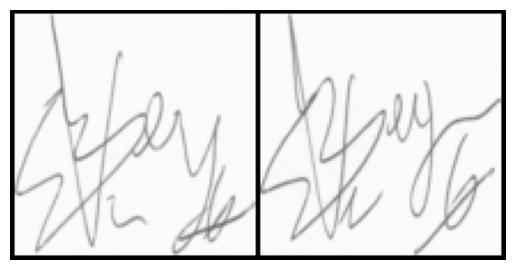

Predicted Eucledian Distance:- 0.2101813405752182
Actual Label:- Original Pair Of Signature


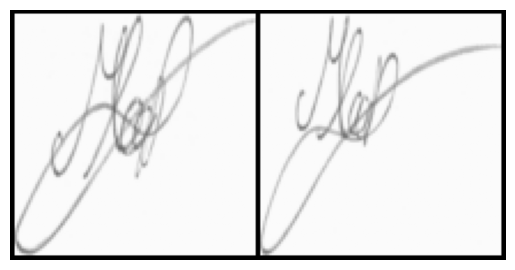

Predicted Eucledian Distance:- 0.13857638835906982
Actual Label:- Original Pair Of Signature


In [15]:
count=0
for i, data in enumerate(test_dataloader,0):
  x0, x1 , label = data
  concat = th.cat((x0,x1),0)
  output1,output2 = model(x0.to(device),x1.to(device))

  eucledian_distance = F.pairwise_distance(output1, output2)

  if label==th.FloatTensor([[0]]):
    label="Original Pair Of Signature"
  else:
    label="Forged Pair Of Signature"

  imshow(torchvision.utils.make_grid(concat))
  print("Predicted Eucledian Distance:-",eucledian_distance.item())
  print("Actual Label:-",label)
  count=count+1
  if count ==10:
    break